## Notes / ToDo
- Cut off the likelihood for high / problematic dedx values (only focus on values located in the region around the peak)
- Look into developing analytic likelihood based on the mpv fit. This would most likely have to take the pitch into account 
- See if single muon fit mpvs have any correlation with fit mpvs. Build likelihood from that alone.


- Langau pdf maximum deviates slightly from the mpv parameter used to generate it. This is clearly because of the Gaussian convolution, but I thought it was worth mentioning. Important to note that this deviation is in the wrong direction---the true maximum is slightly *greater* than the one measured, and so this correction does not solve the problem of the Langau mpvs being higher than expected.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm
import matplotlib.ticker as mticker 
from util.cer_util import CER
import util.cer_util
import warnings
import pylandau
import landaupy
import datetime
import os
from importlib import reload
from scipy.optimize import curve_fit, least_squares
import scipy.stats
from tqdm.auto import tqdm
warnings.filterwarnings('ignore')
plt.style.use('stylesheets/eloss.mplstyle')

## Testing Stuff

In [25]:
df = pd.read_csv('data/mc_dedx_test.csv', index_col=['entry','subentry'])
ldf = pd.read_csv('data/mc_dedxs_large_test.csv', index_col=['entry','subentry'])
df.info()
print()
ldf.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1016146 entries, (0, 0) to (1999, 107)
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   dedx_y  1016146 non-null  float64
dtypes: float64(1)
memory usage: 11.8 MB

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1507626 entries, (0, 0) to (2999, 598)
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   dedx_y  1507626 non-null  float64
dtypes: float64(1)
memory usage: 17.4 MB


In [102]:
test = np.array(lvl0)

In [103]:
test.shape

(1507626,)

In [104]:
ldf.index.get_level_values(0).unique().to_numpy(dtype=int).shape

(3000,)

In [106]:
lvl1 = np.repeat(ldf.index.get_level_values(1), 5)
lvl0 = []
for i in tqdm(range(5)):
    lvl0.extend(ldf.index.get_level_values(0).to_numpy(dtype=int) + int(i*3000))
    
tuples = list(zip(lvl0, lvl1))
new_index = pd.MultiIndex.from_tuples(tuples, names=["entry", "subentry"])
lldf = ldf.append(ldf).append(ldf).append(ldf).append(ldf)
lldf.index=new_index
print(lldf)

  0%|          | 0/5 [00:00<?, ?it/s]

MultiIndex([(    0,   0),
            (    0,   0),
            (    0,   0),
            (    0,   0),
            (    0,   0),
            (    0,   1),
            (    0,   1),
            (    0,   1),
            (    0,   1),
            (    0,   1),
            ...
            (14999, 597),
            (14999, 597),
            (14999, 597),
            (14999, 597),
            (14999, 597),
            (14999, 598),
            (14999, 598),
            (14999, 598),
            (14999, 598),
            (14999, 598)],
           names=['entry', 'subentry'], length=7538130)
                  dedx_y
entry subentry          
0     0         1.712979
      0         1.771888
      0         1.782722
      0         1.857496
      0         1.627619
...                  ...
14999 598       2.151498
      598       1.744625
      598       3.112491
      598       2.070166
      598       1.901588

[7538130 rows x 1 columns]


In [107]:
tqdm.pandas(desc='Groups', unit='muon')
df.groupby(level=0).progress_apply(lambda x: time.sleep(0.01))
lldf.groupby(level=0).progress_apply(lambda x: time.sleep(0.01))

Groups:   0%|          | 0/2000 [00:00<?, ?muon/s]

Groups:   0%|          | 0/15000 [00:00<?, ?muon/s]

KeyboardInterrupt: 

In [3]:
titles = ['Base Likelihood',
          'Cut Likelihood',
          'Cut and Fixed-Width Likelihood',
          'Fixed-Width Likelihood',
          'High-Pitch Cut Likelihood',
          'High-Pitch Likelihood',
          'Low-Pitch Cut Likelihood',
          'Low-Pitch Likelihood',
          'Narrow Energy Cut Likelihood (1-10 GeV)',
          'Narrow Energy Likelihood (1-10 GeV)',
          'Narrow Low-Pitch Fixed-Sigma Likelihood',
          'MC Reconstruction',
          'Delta-RM52',
          'Delta-RM33',
          'MC Reconstruction Test',
          'MC 1% Bias',
          'MC 5% Error']

Move this to a the theory module or something, it is really annoying that this is non-normalized.

## Load Muons

In [2]:
def langau_pdf(dedx, mpv, eta, sig):
    return eta * pylandau.get_langau_pdf(dedx, mpv, eta, sig)

In [3]:
def savefig(fig, name):
    date = datetime.datetime.now()
    month_day = f'{date.month}-{date.day}-{date.year%100}/'
    path = r'./plots/' + month_day + name
    fig.savefig(path, bbox_inches='tight')
    print(f'Saved to {path}')

In [4]:
import time
CER = reload(util.cer_util).CER
cer = CER(dedx_max=10)
start = time.perf_counter()
cer.load_muons()
end = time.perf_counter()
t1 = end-start

print(f'Loading time: {t1//60:.0f}m, {t1%60:.2f}s')

Loading Data...
Loaded!
Slimming...
Will remove 5971 particles
There are 3813 muons left to analyze
Loading time: 0m, 7.45s


## Percent Accuracy
Quick check for how many times we got the correct answer (where the true energy was inside the energy bin predicted by the likelihood)

In [5]:
def get_accuracy(likedf):
    num_correct = likedf.query('truth > reconstructed_min & truth < reconstructed_max').shape[0]
    num_particles = likedf.shape[0]
    percent_correct = num_correct/num_particles * 100
    return percent_correct

## Raw heatmap of reconstructed energy vs true energy

In [6]:
def plot_2d_hist(likedf, fitdf, ax):
    ebins = fitdf.e_min.to_list()
    ebins.append(fitdf.e_max.iloc[-1])
    ebins = np.array(ebins)
    
    x = np.linspace(0, 100, 1000)

    truth = likedf.truth
    reconstructed = likedf[["reconstructed_min", "reconstructed_max"]].mean(1)
    counts, xedges, yedges, _ = ax.hist2d(truth, reconstructed, bins=[ebins,ebins], norm=LogNorm(0.7), cmap='gist_heat_r')
    ax.plot(x,x, color='k', ls='--') # Plot the expectation, which is ideally perfect reconstruction (a 45 degree line)
    ax.set_xlabel('True Energy (GeV)')
    ax.set_ylabel('Reconstructed Energy (GeV)')
    ax.set_title('TE vs. RE')
    # ax.set_ylim(0.5, 45) # Cuts off the bins that comprise the border of the image, these bins continue to either 0.1 or 100 GeV, but drawing them fully makes the graph confusing
    # ax.set_xlim(0.5, 45)
    ax.set_xscale('linear')
    ax.set_yscale('linear')
    return counts, xedges, yedges

In [7]:
def plot_averages(likedf, counts, xedges, yedges, ax):
    acc = get_accuracy(likedf)
    
    x = np.linspace(0, 100, 1000)
    REs = 10**((np.log10(yedges[1:])+np.log10(yedges[:-1]))/2)
    TEs = 10**((np.log10(xedges[1:])+np.log10(xedges[:-1]))/2)
    average_reconstruction = [ np.sum(xcount*REs/np.sum(xcount)) for xcount in counts ]
    
    ax.errorbar(TEs, average_reconstruction, marker='o', label=f'Average E bin \nCorrect RE rate: {acc:.2f}%', ls='')
    ax.set_title('Average R.E. vs. T.E.')
    ax.set_ylabel('Average R.E. (GeV)')
    ax.set_xlabel('True Energy (GeV)')
    ax.plot(x,x, color='k', ls='--', label='Expectation')
    ax.legend()
    ax.set_ylim(0.1, 100)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid()

In [8]:
def re_format(ax):
    ax.xaxis.set_minor_locator(mticker.MaxNLocator(integer=True))
    ax.yaxis.set_minor_locator(mticker.MaxNLocator(integer=True))
    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())

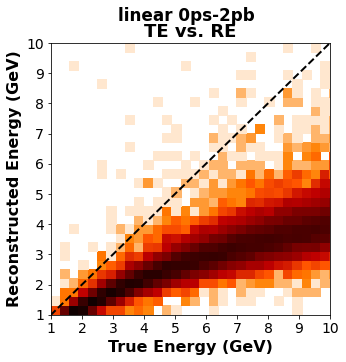

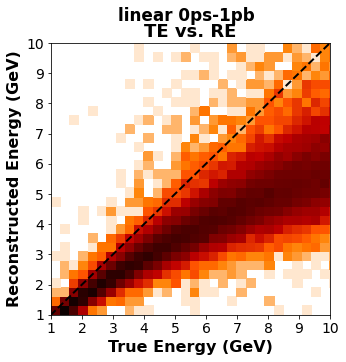

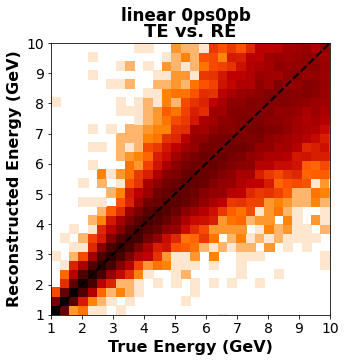

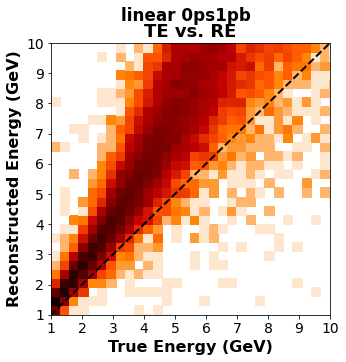

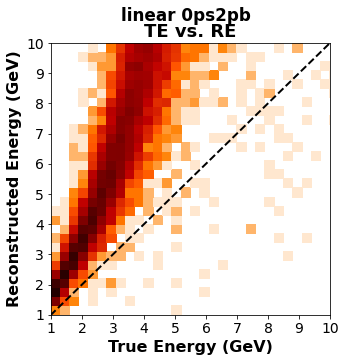

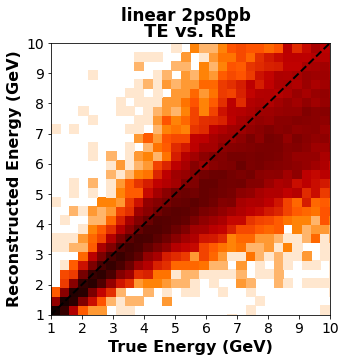

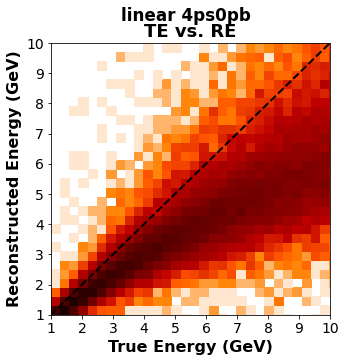

In [9]:
plt.rcParams['axes.grid']=False
# keys_to_plot = ['mcth_0ps0pb', 'mcth_2ps0pb', 'mcth_4ps0pb', 'mcth_6ps0pb', 'mcth_8ps0pb', 'mcth_10ps0pb']
keys_to_plot = ['mcth_0ps-2pb', 'mcth_0ps-1pb', 'mcth_0ps0pb', 'mcth_0ps1pb', 'mcth_0ps2pb', 'mcth_2ps0pb', 'mcth_4ps0pb']

def plot_likelihood_results(data_loc, fit_loc, title, save=False):
    fig, ax = plt.subplots(figsize=(5,5))
    fig.suptitle(title, fontweight='bold')
    df = pd.read_csv(data_loc)
    fdf = pd.read_csv(fit_loc)
    ret = plot_2d_hist(df, fdf, ax)
    # plot_averages(df, *ret, axs[1])
    re_format(ax)
    ax.set_xlim(1,10)
    ax.set_ylim(1,10)
    
    # if 'narrow' in data_loc or 'mc' in data_loc or 'delta_rm' in data_loc:
    #     for ax in axs:
    #         re_format(ax)
    #         ax.set_ylim(1,10) 
    #         ax.set_xlim(1,10)
    # if 'mc_theory' in data_loc:
    #     for ax in axs:
    #         re_format(ax)
    #         ax.set_ylim(0.4,10.6) 
    #         ax.set_xlim(0.4,10.6)
    #         ax.set_xscale('linear')
    #         ax.set_yscale('linear')
            
        
    fig.show()
    if save:
        savefig(fig, title.replace(' ', '_') + '_reconstruction.png')
    
for key in keys_to_plot:
    loc = cer.reconstructions[key]
    floc = cer.fits[key]
    plot_likelihood_results(loc, floc, loc.split('/')[-1].replace('_', ' ')[:-4], save=False)

plt.rcParams['axes.grid']=True

## Binned Distributions at certain true / reconstructed energies

In [19]:
key = 'mcth_0ps0pb'
likedf = pd.read_csv(cer.reconstructions[key])
fitdf = pd.read_csv(cer.fits[key])

<AxesSubplot:xlabel='truth', ylabel='num high RE - num low RE'>

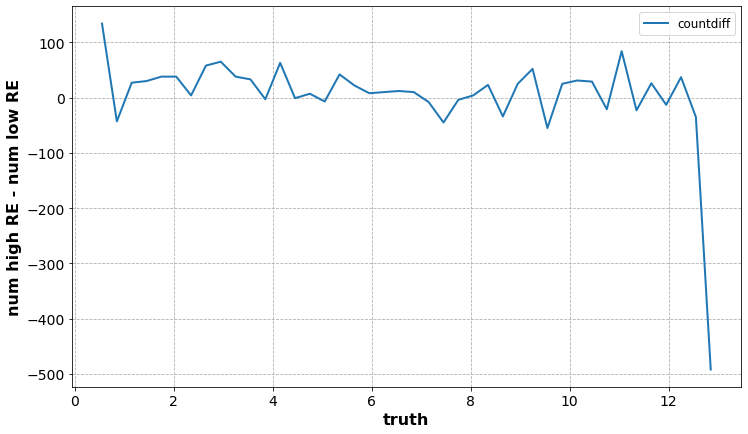

In [20]:
countdiffs = likedf.groupby('truth').apply(
    lambda df: 
        pd.Series(np.sum(df.reconstructed_min > df.truth) - np.sum(df.reconstructed_max < df.truth),
                  index=['countdiff'])
    )
countdiffs.plot(ls='-', ylabel='num high RE - num low RE')

In [21]:
def get_binned_diff_dist(diff, truth, density=True):
    
    bins = np.append(fitdf.e_min, fitdf.e_max.iloc[-1])
    difference_bins = bins - truth
    
    counts, _ = np.histogram(diff, difference_bins, density=density)
    difference_bin_centers = (difference_bins[1:] + difference_bins[:-1]) / 2
    
    return difference_bin_centers, counts


def gaussdiff(df):
    if df.truth.unique().shape[0] != 1:
        raise ValueError('df must be a slice containing one true energy value')
        
    diff = df['difference']
    truth = df.truth.iloc[0]
    bcenters, counts = get_binned_diff_dist(diff, truth)
    
    mask = (bcenters < truth) & (bcenters > -truth)
    bcenters = bcenters[mask]
    counts = counts[mask]
    
    def gaussian(x, mu, sig):
        return scipy.stats.norm.pdf(x, mu, sig)
    
    popt, pcov = curve_fit(gaussian, bcenters, counts)
    
    perr = np.sqrt(np.diag(pcov))
    return np.append(np.append(popt, perr), truth)

In [22]:
likedf['reco'] = likedf[['reconstructed_min', 'reconstructed_max']].mean(axis=1)
likedf['difference'] = likedf.reco - likedf.truth


# Requires dataframe to contain muons of true energy monotonically increasing
muons_per_ebin = likedf.truebin.loc[likedf.truebin == 1].index[0] # Finds location of first muon in true bin 1
num_bins = fitdf.shape[0]

gaussian_data = []
for idx in tqdm(range(num_bins)):
    df = likedf.loc[likedf.truebin == idx]
    gaussian_data.append(gaussdiff(df))

gausses = pd.DataFrame(gaussian_data, columns=['gloc', 'gwidth', 'gloc_err', 'gwidth_err', 'truth'])

  0%|          | 0/42 [00:00<?, ?it/s]

### Plot Percent Bias

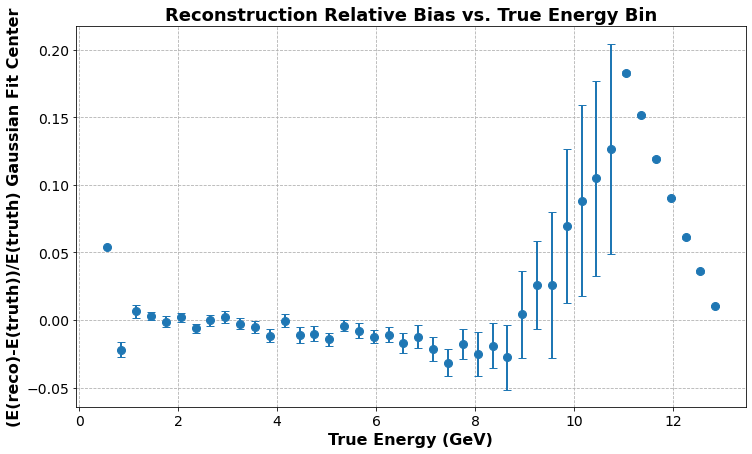

In [23]:
truth = gausses.truth
pct_bias = gausses.gloc / truth
pct_bias_err = gausses.gloc_err / truth

plt.figure()
plt.errorbar(truth, pct_bias, yerr=pct_bias_err, marker='o')
plt.title('Reconstruction Relative Bias vs. True Energy Bin')
plt.xlabel('True Energy (GeV)')
plt.ylabel('(E(reco)-E(truth))/E(truth) Gaussian Fit Center')
# plt.ylim(-0.1, 1.1)
# savefig(plt.gcf(), '1pbias_Relative_Bias_vs_TE_Bin.png')
plt.show()

### Plot Percent Resolution

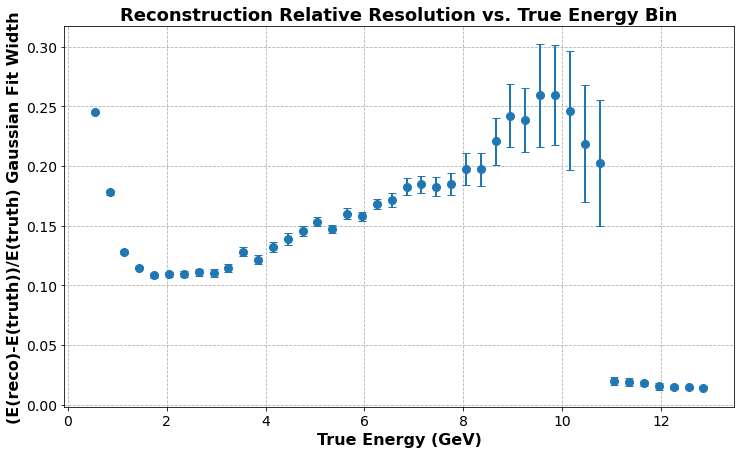

In [24]:
truth = gausses.truth
pct_resolution = gausses.gwidth / truth
pct_resolution_err = gausses.gwidth_err / truth

plt.figure()
plt.errorbar(truth, pct_resolution, yerr=pct_resolution_err, marker='o')
plt.title('Reconstruction Relative Resolution vs. True Energy Bin')
plt.xlabel('True Energy (GeV)')
plt.ylabel('(E(reco)-E(truth))/E(truth) Gaussian Fit Width')
# plt.ylim(-0.1, 0.9)
# savefig(plt.gcf(), '1perror_Relative_Resolution_vs_TE_Bin.png')
plt.show()

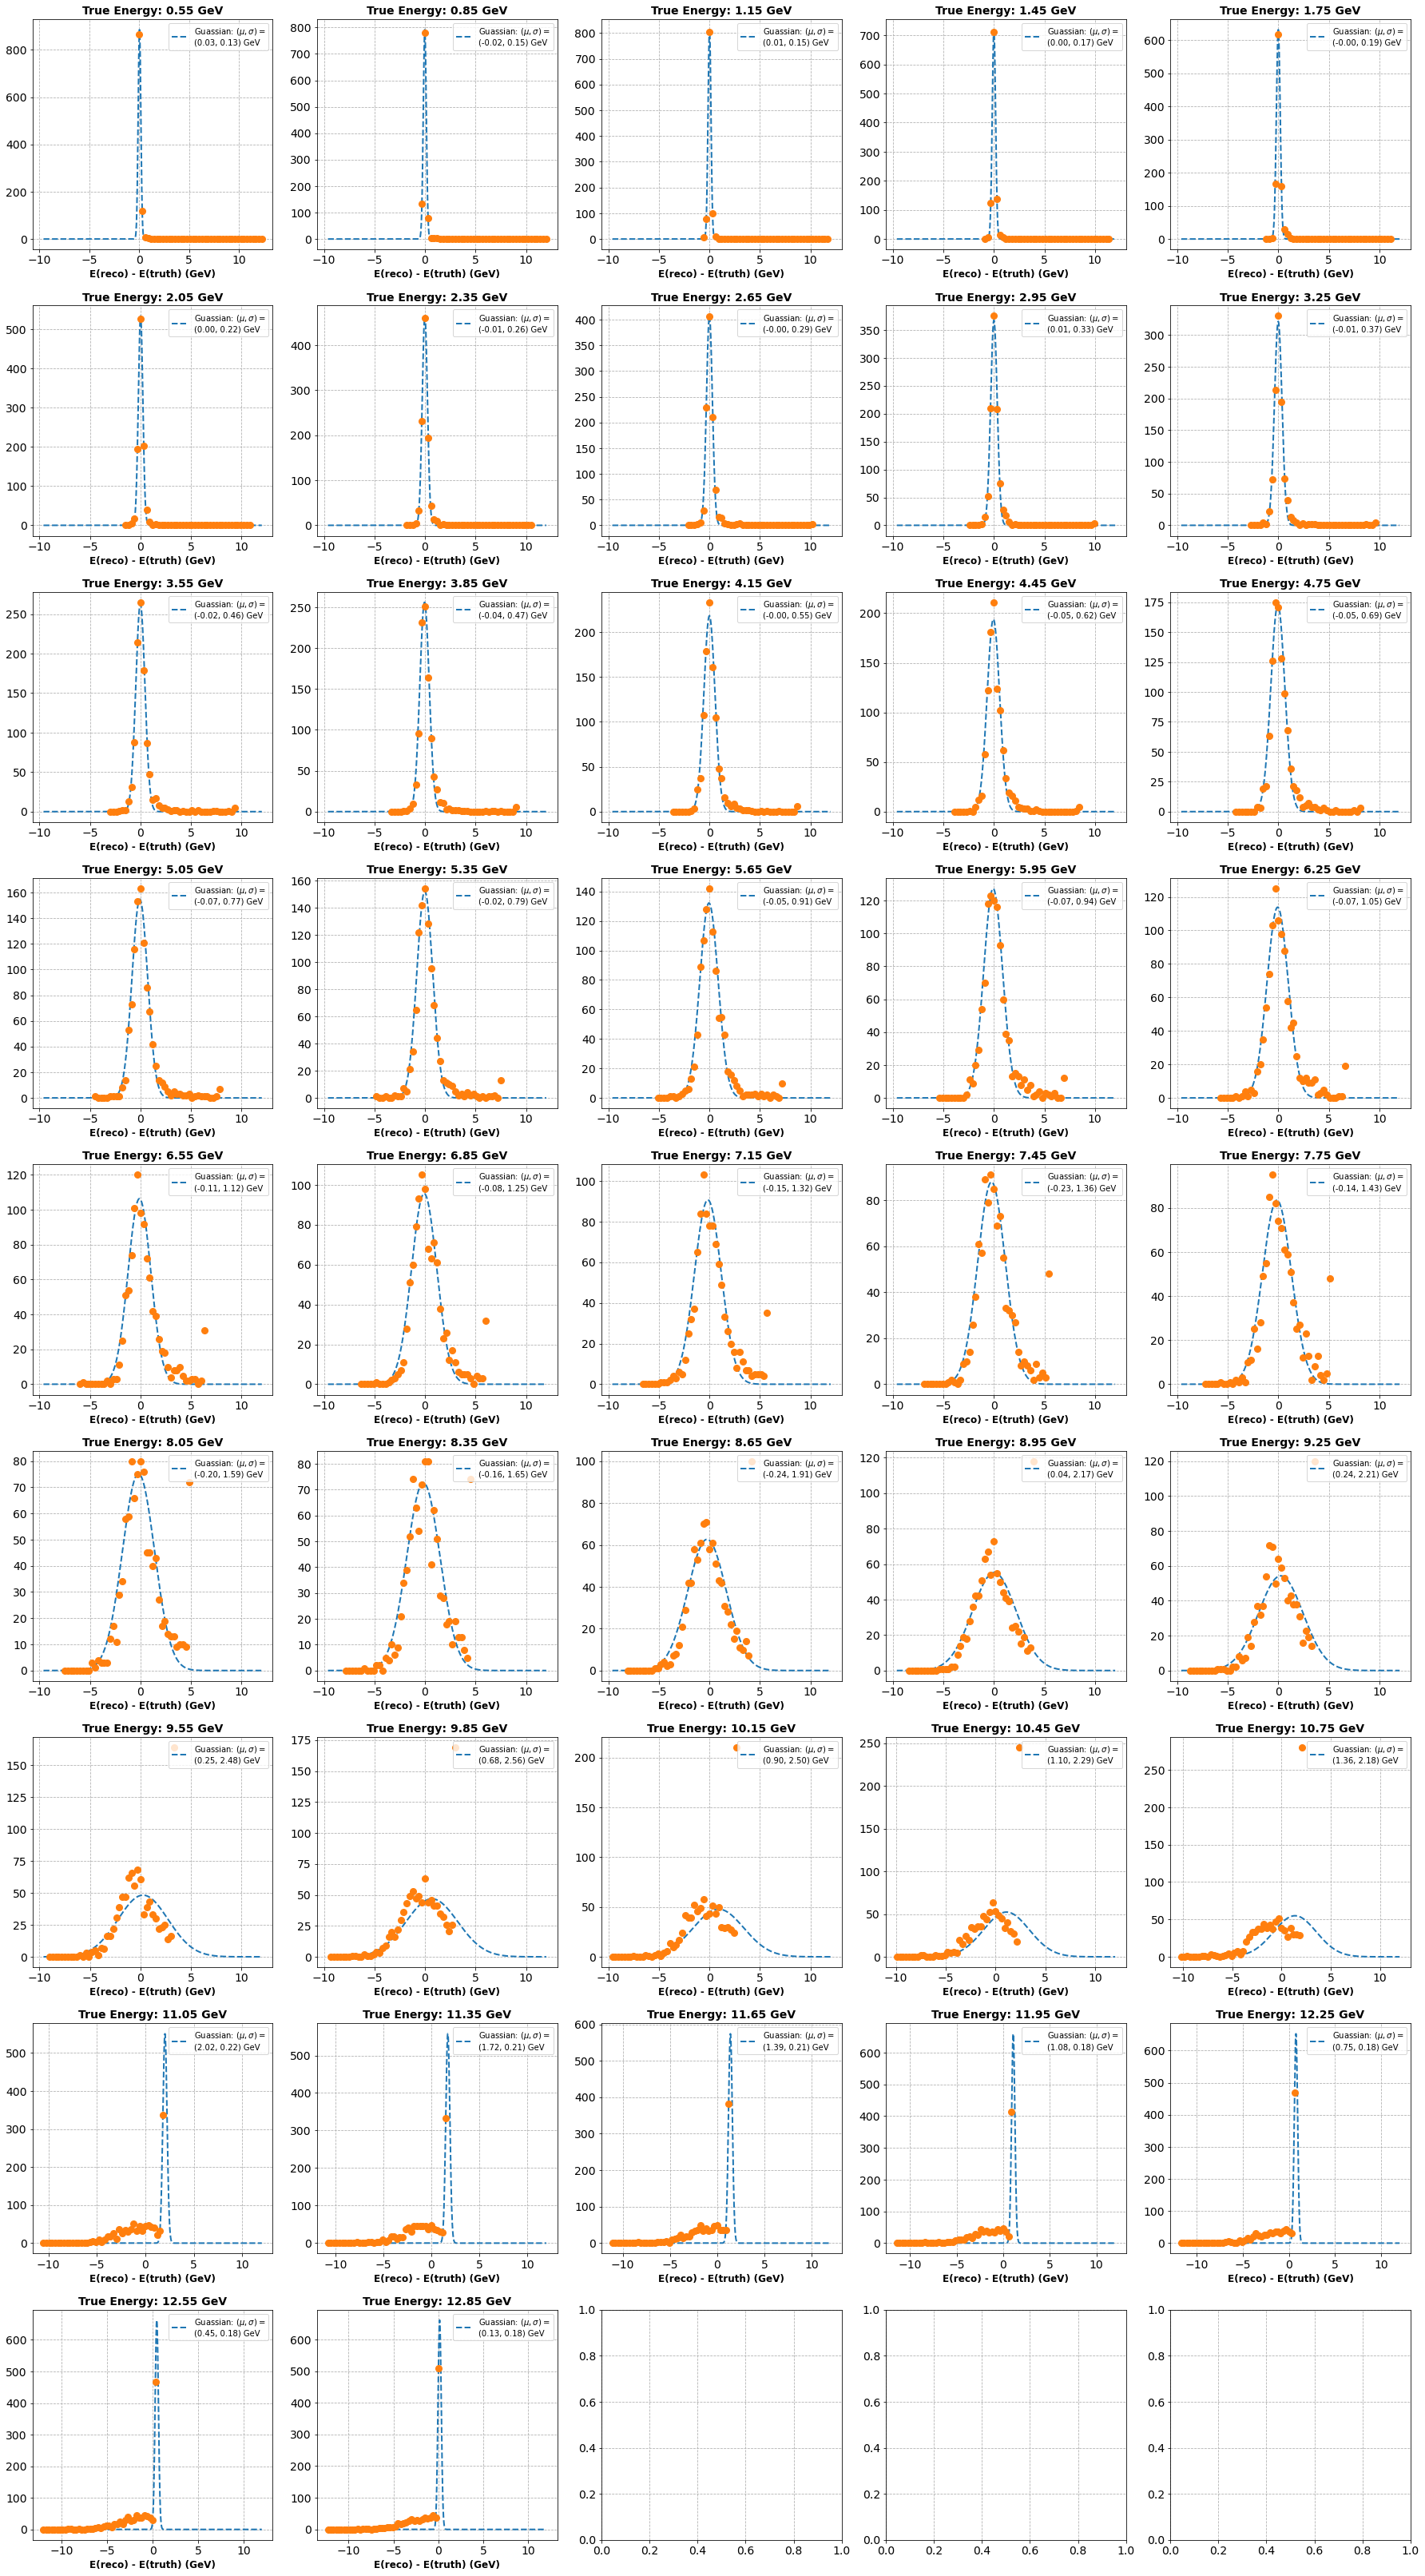

In [25]:
ncols = 5
nrows = gausses.shape[0]//ncols+1
fig, axes = plt.subplots(gausses.shape[0]//ncols+1, ncols, figsize=(ncols*5, nrows*5))
for row, ax in zip(gausses.iterrows(), axes.flatten()):
    i, data = row
    gloc, gwidth, gloc_err, gwidth_err, truth = data
    x = np.linspace(min(likedf.difference), max(likedf.difference), 1000)
    y = scipy.stats.norm.pdf(x, gloc, gwidth)
    
    differences = likedf.loc[likedf.truebin == i].difference
    bin_centers, counts = get_binned_diff_dist(differences, truth, density=False)
    anorm = np.sum(counts)*(bin_centers[1]-bin_centers[0]) # Assumes linear bins!
        
    ax.plot(x, y*anorm, ls='--',
             label=r'Guassian: $(\mu, \sigma)=$' + f'\n({gloc:.2f}, {gwidth:.2f}) GeV')
    ax.plot(bin_centers, 
            counts, 
            marker='o',
            )
    ax.set_title(f'True Energy: {truth:.2f} GeV', fontsize=14)
    ax.legend(loc='upper right', fontsize=10)
    ax.set_xlabel('E(reco) - E(truth) (GeV)', fontsize=12)

fig.tight_layout()
# savefig(fig, '1pbias_difference_distributions.png')
fig.show()

In [26]:
def normalize_and_compute_errors(counts, bins):
    bin_centers = (bins[1:]+bins[:-1])/2
    bin_width = bins[1] - bins[0] # Assumes linear bins
    norm = np.sum(counts) * bin_width
    normalized_counts = counts / norm
    normalized_errors = np.sqrt(counts) / norm
    return bin_centers, normalized_counts, normalized_errors

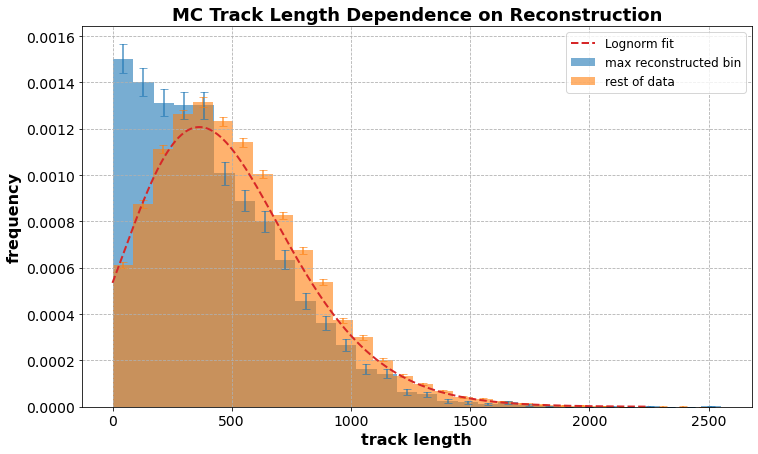

In [27]:
num_bins = 30
max_reco = likedf.reco.max()
max_reco_df = likedf.loc[likedf.reco == max_reco]
sub_max_reco_df = likedf.loc[likedf.reco < max_reco]
sub_counts, sub_bins = np.histogram(sub_max_reco_df.track_length, bins=num_bins)
max_counts, max_bins = np.histogram(max_reco_df.track_length, bins=num_bins)

sub_ebar_data = normalize_and_compute_errors(sub_counts, sub_bins)
max_ebar_data = normalize_and_compute_errors(max_counts, max_bins)

plt.figure()
plt.hist(max_reco_df.track_length, bins=30, density=True, alpha=0.6, label='max reconstructed bin')
plt.hist(sub_max_reco_df.track_length, bins=30, density=True, alpha=0.6, label='rest of data')
plt.errorbar(*sub_ebar_data, color='tab:orange', alpha=0.6)
plt.errorbar(*max_ebar_data, color='tab:blue', alpha=0.6)
x = np.linspace(0, 2250, 1000)
plt.plot(x, scipy.stats.lognorm.pdf(x, 2.01980595e-01, -1.23848172e+03, 1.66933758e+03 ), ls='--', color='tab:red', label='Lognorm fit')
plt.xlabel('track length')
plt.ylabel('frequency')
plt.title('MC Track Length Dependence on Reconstruction')
plt.legend()
# savefig(plt.gcf(), '5perror_track_length_dependence.png')
plt.show()

In [82]:
likedf['trkl_category'] = pd.cut(likedf.track_length, 50)

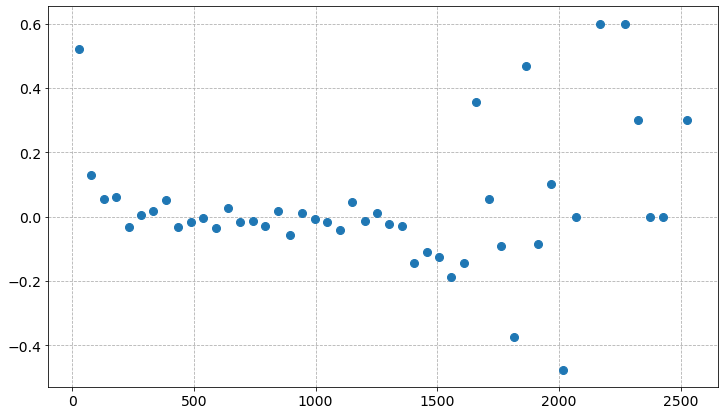

In [83]:
trkl_df = likedf.groupby('trkl_category').difference.mean()
trkls = [ interval.mid for interval in trkl_df.index ] 
plt.plot(trkls, trkl_df.values, marker='o')

In [98]:
re = likedf[["reconstructed_min", "reconstructed_max"]].mean(1)
ebins = [ fitdf.e_min[0] ] + fitdf.e_max.to_list()

In [111]:
def plot_re_dist(telo, tehi, highlight=False, otherdist=None, save=False, i=0):
    df_ebin = likedf.query(f'truth < {tehi} & truth > {telo}')
    re_centers = df_ebin[["reconstructed_min", "reconstructed_max"]].mean(1) - df_ebin.truth
    if otherdist is not None:
        re_centers = otherdist
    
    
    fig = plt.figure(figsize=(10, 5))
    ax = fig.gca()
    counts = ax.hist(re_centers, np.array(ebins)-(tehi+telo)/2, edgecolor='black', lw = '1.2')[0]
    ax.plot([],[],label=f'tot. = {np.sum(counts):.0f} particles')
    if highlight:
        minloc, maxloc = np.digitize([telo, tehi], ebins) - 1
        if np.isin([tehi], ebins)[0]:
            maxloc -= 1
        highlight_bins = [telo, *ebins[minloc+1:maxloc], tehi]
        ax.hist(re_centers, highlight_bins, color='r', edgecolor='black', lw = '1.2', label="correct bin")
        
    ax.set_xlabel('Reconstructed Energy (GeV)')
    ax.set_ylabel('Counts')
    ax.set_title(fr'R.E.-T.E. Distribution for T.E.$\in$({telo:.2f},{tehi:.2f}) GeV')
    # ax.set_xlim(1, 10)
    ax.legend()
    fig.show()
    if save:
        savefig(fig, fr'REmTE_Dists/RE_dist_for_TE_bin{i}.png')
    return fig, counts

In [112]:
def plot_te_dist(relo, rehi, highlight=False, save=False, i=0):
    df_ebin = likedf.query(f'(reconstructed_min+reconstructed_max)/2 < {rehi} & (reconstructed_min+reconstructed_max)/2 > {relo}')
    te = df_ebin.truth
    fig, _ = plot_re_dist(relo, rehi, highlight=highlight, otherdist=te)
    plt.xlabel('True Energy (GeV)')
    plt.title(fr'T.E. Distribution for R.E.$\in$({relo:.2f},{rehi:.2f}) GeV')
    if save:
        savefig(fig, fr'RE_Dists/TE_dist_for_RE_bin{i}.png')

Saved to ./plots/2-3/REmTE_Dists/RE_dist_for_TE_bin0.png
Saved to ./plots/2-3/REmTE_Dists/RE_dist_for_TE_bin1.png
Saved to ./plots/2-3/REmTE_Dists/RE_dist_for_TE_bin2.png
Saved to ./plots/2-3/REmTE_Dists/RE_dist_for_TE_bin3.png
Saved to ./plots/2-3/REmTE_Dists/RE_dist_for_TE_bin4.png
Saved to ./plots/2-3/REmTE_Dists/RE_dist_for_TE_bin5.png
Saved to ./plots/2-3/REmTE_Dists/RE_dist_for_TE_bin6.png
Saved to ./plots/2-3/REmTE_Dists/RE_dist_for_TE_bin7.png
Saved to ./plots/2-3/REmTE_Dists/RE_dist_for_TE_bin8.png
Saved to ./plots/2-3/REmTE_Dists/RE_dist_for_TE_bin9.png


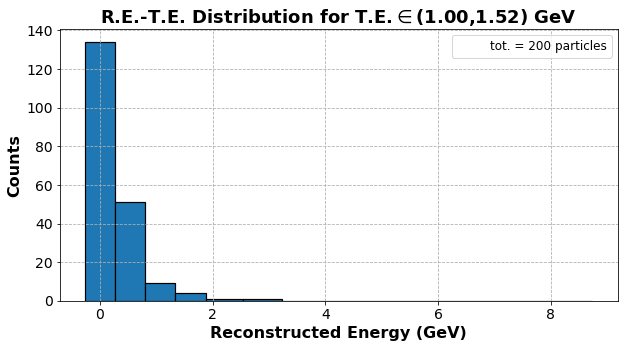

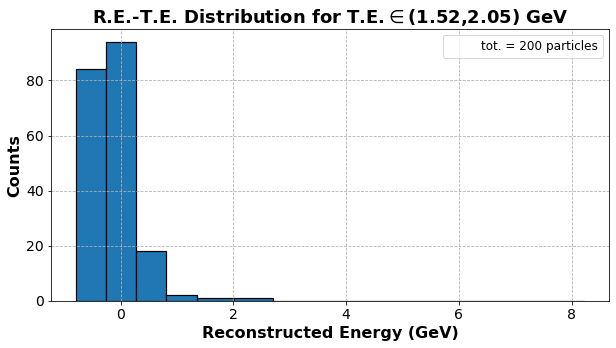

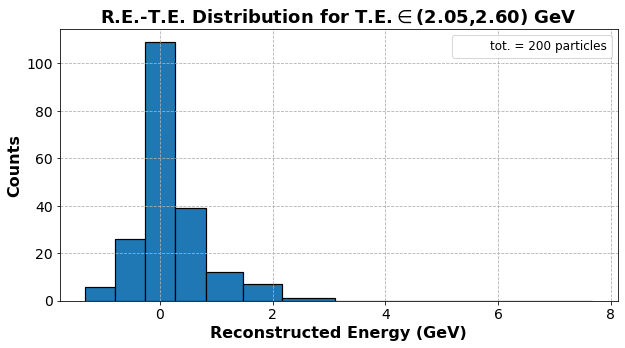

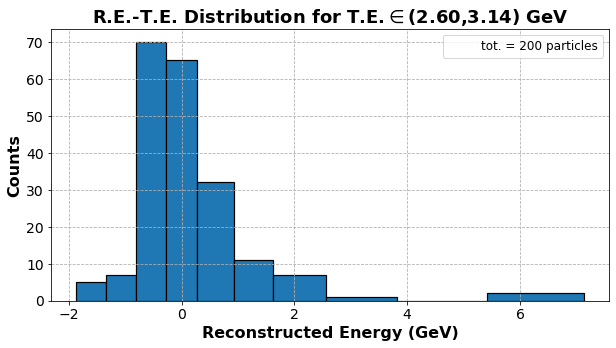

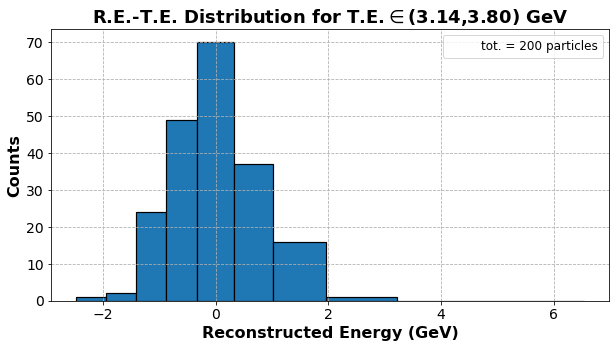

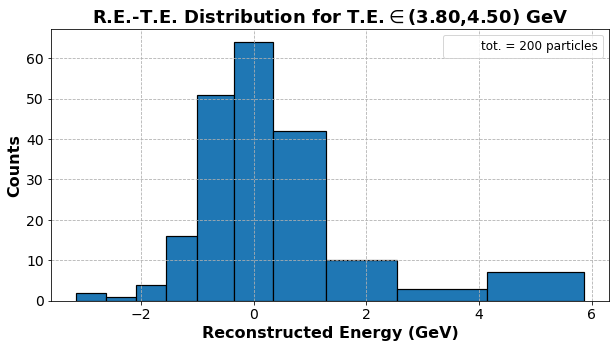

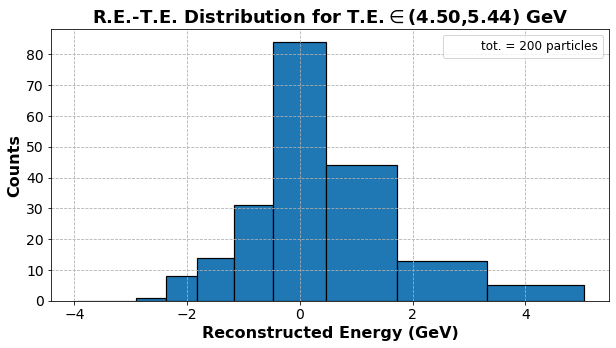

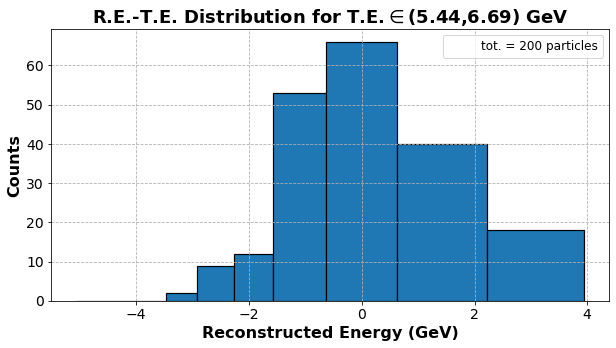

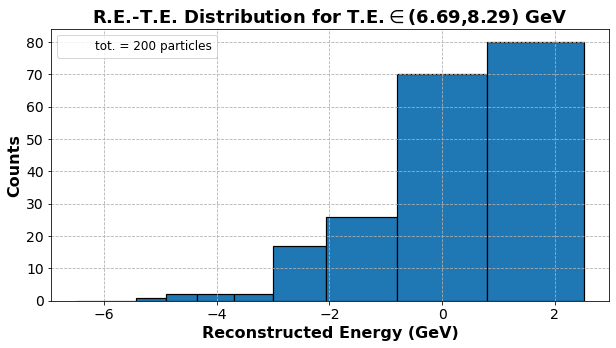

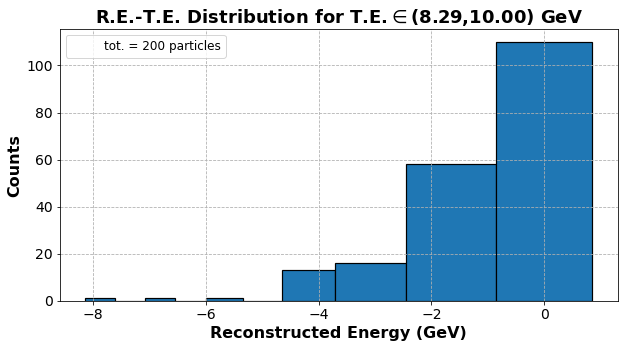

In [113]:
for i in range(0,len(ebins)-1):
    counts = plot_re_dist(ebins[i], ebins[i+1], highlight=False, save=True, i=i)

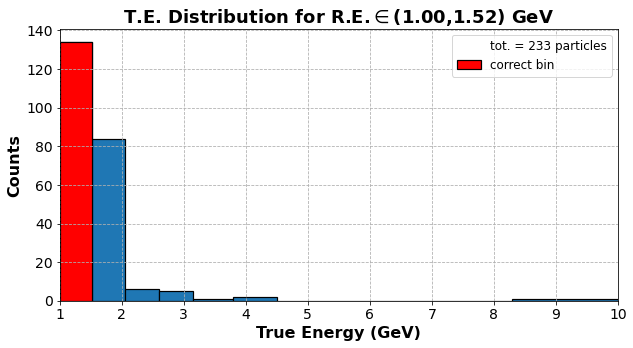

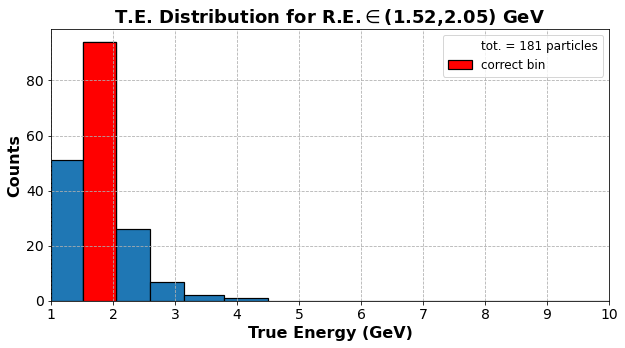

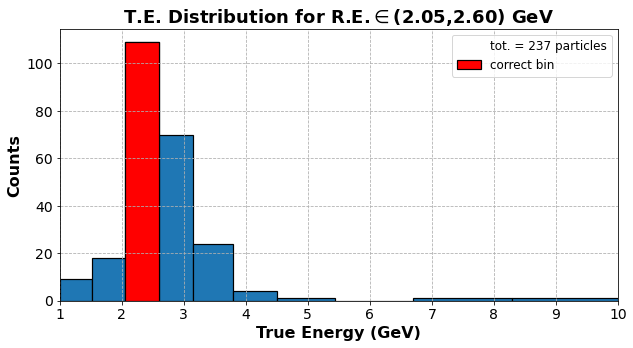

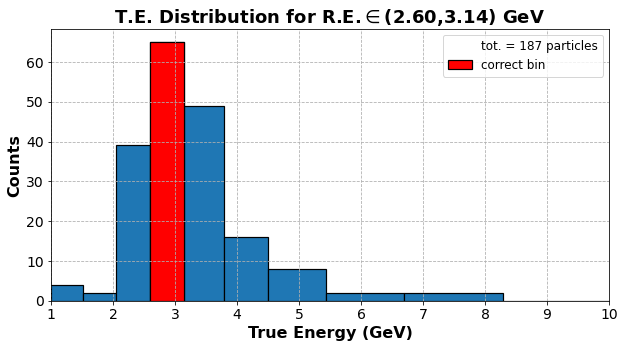

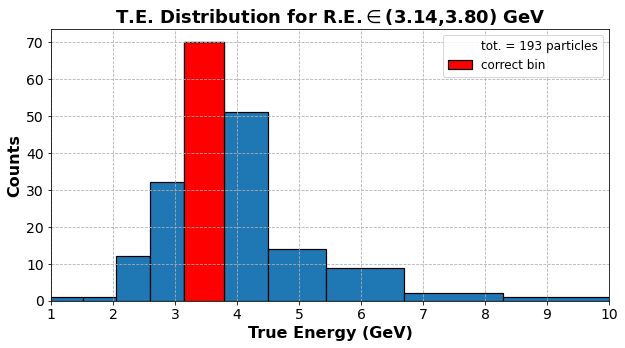

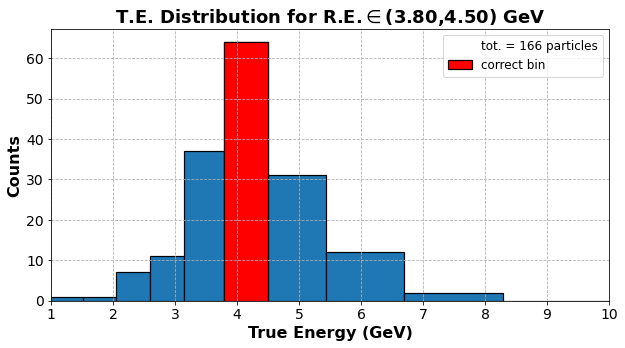

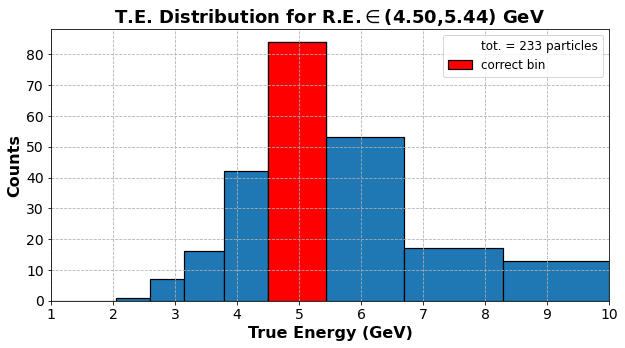

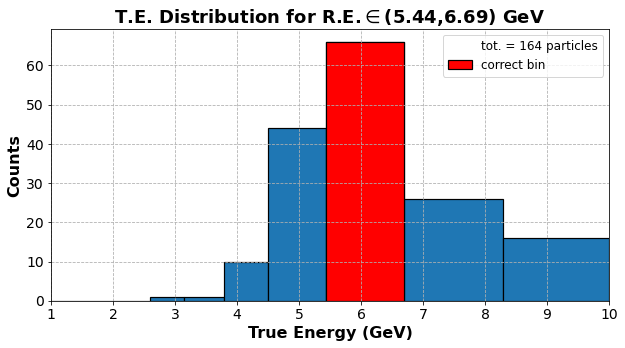

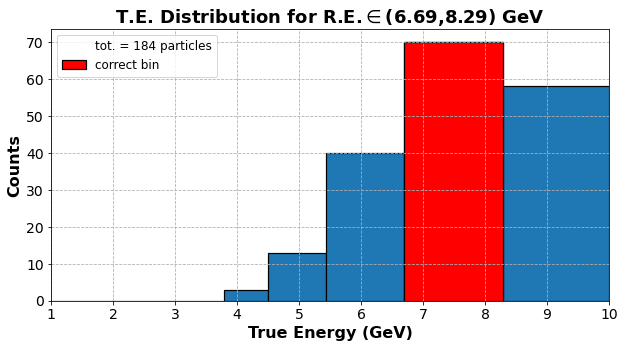

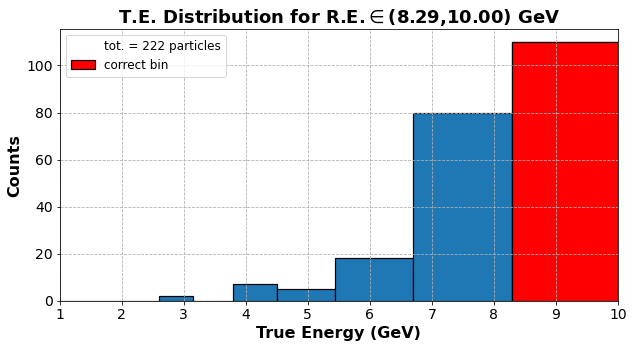

In [72]:
for i in range(0,len(ebins)-1):
    counts = plot_te_dist(ebins[i], ebins[i+1], highlight=True)

Multiply by prior probability distribution to obtain more appropriate probability for the likelihood. This will require knowing the prior, which can just be the probability distribution of cosmic muons as a function of energy, which I assume is generally well-understood.

## Dependence on track length
Here I explore further the idea that the track length of the particle has a confounding effect on the likelihood

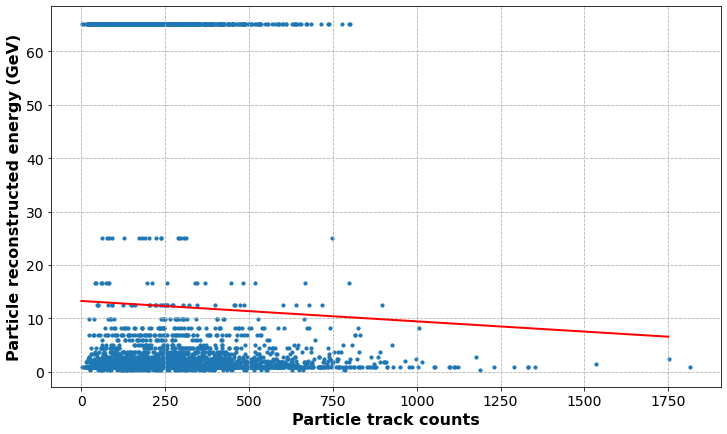

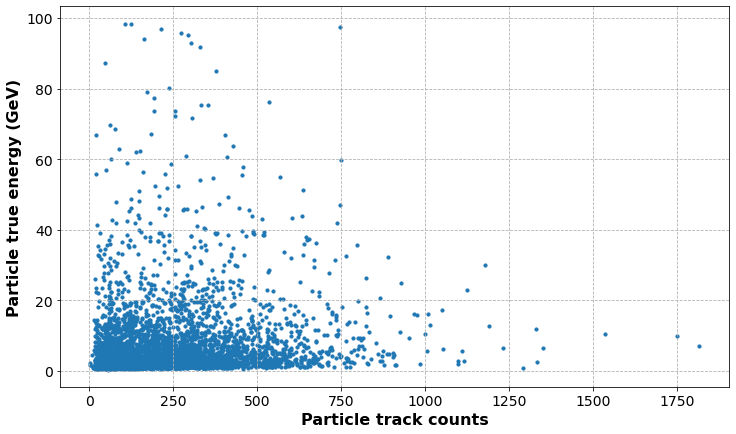

In [25]:
trkl = []
for mu in cer.muons:
    l = mu.dedx_y.shape[0]
    trkl.append(l)


popt, pcov = curve_fit(lambda x,a,b: a*x+b, trkl, re)
fig = plt.figure()
plt.scatter(trkl, re, s=10)
_x = np.linspace(0,1750, 1000)
_y = popt[0] * _x + popt[1]
plt.plot(_x,_y, ls='-', c='r')
plt.xlabel('Particle track counts')
plt.ylabel('Particle reconstructed energy (GeV)')
plt.show()
plt.figure()
plt.scatter(trkl, truth, s=10)
plt.xlabel('Particle track counts')
plt.ylabel('Particle true energy (GeV)')
plt.show()

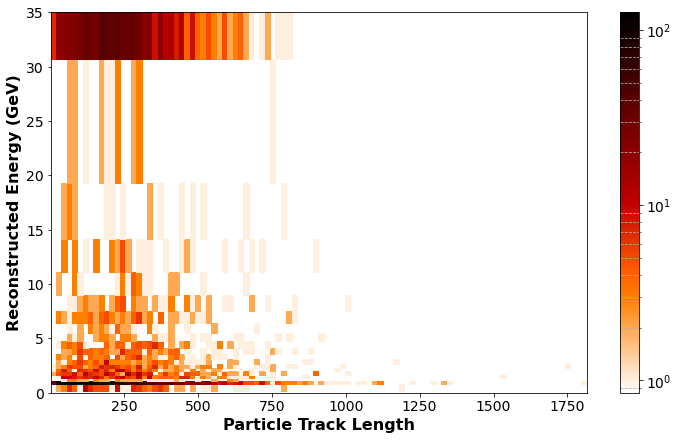

In [26]:
plt.hist2d(trkl, re, bins=[100, ebins], norm=LogNorm(vmin=0.85), cmap='gist_heat_r')
plt.ylim(0,35)
plt.colorbar()
plt.ylabel('Reconstructed Energy (GeV)')
plt.xlabel('Particle Track Length')
plt.show()

## Selection Cuts
Just want to visualize the selection cuts I have made quickly here. With the full dataset, I cannot load everything contiguously in memory, so I have to go a little lower-level here

In [1]:
import uproot
unfiltered_pitches = []
with uproot.open('./data/simulated_cosmics_full.root:/nuselection/CalorimetryAnalyzer') as tree:
    unfiltered_pitches = tree.arrays('pitch_y', library='pd')

TypeError: 'Muons' object is not iterable

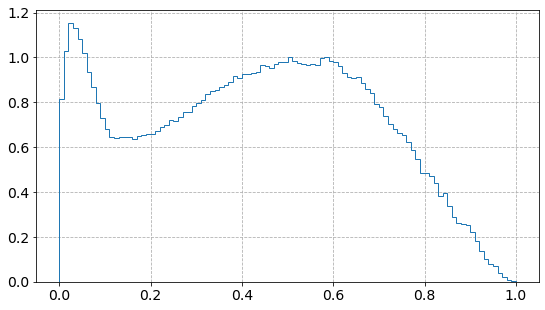

In [8]:
fig = plt.figure(figsize=(9,5))
ucounts, ubins = np.histogram(0.3/unfiltered_pitches, 100)
plt.hist(ubins[:-1], ubins, weights=ucounts/ucounts[50], histtype='step', label='unfiltered muon pitches')

filtered_pitches = np.array([i for muon in cer.muons for i in muon.pitch_y])
fcounts, fbins = np.histogram(0.3/filtered_pitches, 100)
plt.hist(fbins[:-1], fbins, weights=fcounts/fcounts[50], histtype='step', label='filtered muon pitches')
plt.legend()
plt.xlabel(r'$\cos(\gamma)$')
plt.ylabel(r'Density')
plt.title('Pitch Initial Selection Cut')
plt.show()

print('Average filtered pitch:', 0.3/np.sum((fbins[1:]+fbins[:-1])/2*fcounts/np.sum(fcounts)))

In [29]:
unfiltered_dedx = []
with uproot.open('./data/simulated_cosmics_full.root:/nuselection/CalorimetryAnalyzer') as tree:
    unfiltered_dedx = tree.arrays('dedx_y', library='pd')

In [31]:
fig = plt.figure(figsize=(9,5))
ucounts, ubins = np.histogram(unfiltered_dedx[(unfiltered_dedx < 100) & (unfiltered_dedx != np.NaN)], 100)
plt.hist(ubins[:-1], ubins, weights=ucounts, histtype='step', label='unfiltered muon dedx')

filtered_dedx = np.array([i for muon in cer.muons for i in muon.dedx_y])
fcounts, fbins = np.histogram(filtered_dedx, 100)
plt.hist(fbins[:-1], fbins, weights=fcounts, histtype='step', label='filtered muon dedx')
plt.xlim(0, 500)
# plt.legend()
# plt.xlabel(r'$\cos(\gamma)$')
# plt.ylabel(r'Density')
# plt.title('Pitch Initial Selection Cut')
plt.show()

ValueError: autodetected range of [nan, nan] is not finite

<Figure size 648x360 with 0 Axes>